In [41]:
from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates
from qiskit.transpiler import PassManager
import qiskit.quantum_info as qi
import numpy as np

In [42]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
backend = provider.get_backend('ibmq_bogota') # checking gate directions
backend_config = backend.configuration()

ibmqfactory.load_account:WARNING:2022-02-09 13:58:12,676: Credentials are already in use. The existing account in the session will be replaced.


## Cover of the Controlled Ry gate

Play with the perameters to see how much of the space is covered using C-Ry gates.  It seems like we have a pretty good covering.  I have not been able to come up with a state that is not covered.

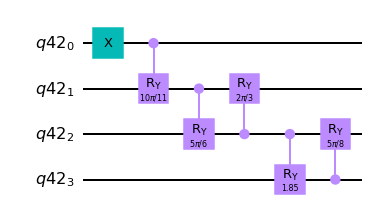

In [208]:
from qiskit.circuit.library.standard_gates import RYGate

def cry(phi):
    return RYGate(phi).control(1)

qr = QuantumRegister(4)
qc = QuantumCircuit(qr)
qc.x(0)
qc.append(cry(np.pi/1.1), [0,1])
qc.append(cry(np.pi/1.2), [1,2])
qc.append(cry(np.pi/1.5), [2,1])
qc.append(cry(np.pi/1.7), [2,3])
qc.append(cry(np.pi/1.6), [3,2])
#qc.append(cry(np.pi), [2,1])
#qc.append(cry(np.pi), [1,0])
qc.draw(output = "mpl")

In [44]:
psi2 = qi.Statevector.from_instruction(qc)

psi2

Statevector([ 0.        +0.j,  0.14231484+0.j,  0.        +0.j,
              0.25618464+0.j,  0.        +0.j, -0.49898255+0.j,
              0.        +0.j,  0.28808771+0.j,  0.        +0.j,
              0.54940159+0.j,  0.        +0.j, -0.31719716+0.j,
              0.        +0.j, -0.36709841+0.j,  0.        +0.j,
              0.21194437+0.j],
            dims=(2, 2, 2, 2))


## Write C-Ry in terms of Rzx

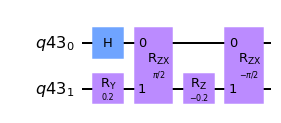

In [209]:
qr = QuantumRegister(2)
qc1 = QuantumCircuit(qr)
qc2 = QuantumCircuit(qr)

qc1.h(0)
qc1.ry(0.2,1)
qc1.rzx(np.pi/2,0,1)
qc1.rz(-0.2,1)
qc1.rzx(-np.pi/2,0,1)

qc2.h(0)
qc2.append(cry(0.4), [0,1])

qc1.draw(output = "mpl")

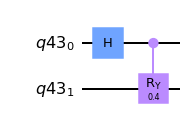

In [210]:
qc2.draw(output = "mpl")

In [211]:
psi1 = qi.Statevector.from_instruction(qc1)
psi2 = qi.Statevector.from_instruction(qc2)

psi1

Statevector([7.07106781e-01+9.81307787e-18j,
             6.93011723e-01+1.38777878e-17j,
             9.81307787e-18+0.00000000e+00j,
             1.40480431e-01+5.55111512e-17j],
            dims=(2, 2))


In [212]:
psi2

Statevector([0.70710678+0.j, 0.69301172+0.j, 0.        +0.j,
             0.14048043+0.j],
            dims=(2, 2))


In [213]:
np.amax(np.abs(psi2-psi1))

2.2247786310271853e-16

## Try to find another expression for C-Ry for which Rzx has smaller angles

In [97]:
import qiskit.quantum_info as qi

def I(N):
    label = ['I' for i in range(N)]
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])

In [129]:
import pandas as pd 

phi = 0.3
def CRy(phi):
    return 1/2*( I(2)*(1+np.cos(phi)) + Z(0,2)*(1-np.cos(phi)) - 1j*np.sin(phi)*Y(1,2) + 1j*np.sin(phi)*Mdot([Z(0,2),Y(1,2)]) )

pd.DataFrame(CRy(phi))

,0,1,2,3
0,1.0+0.0j,0.0+0.0j,0.000000+0.000000j,0.000000+0.000000j
1,0.0+0.0j,1.0+0.0j,0.000000+0.000000j,0.000000+0.000000j
2,0.0+0.0j,0.0+0.0j,0.955336+0.000000j,-0.295520+0.000000j
3,0.0+0.0j,0.0+0.0j,0.295520+0.000000j,0.955336+0.000000j


In [160]:
def Ry(phi):
    return np.cos(phi)*I(2) - 1j*np.sin(phi)*Y(1,2)
def Rz(phi):
    return np.cos(phi)*I(2) - 1j*np.sin(phi)*Z(0,2)
def Rzy(phi):
    return np.cos(phi)*I(2) - 1j*np.sin(phi)*Mdot([Z(0,2),Y(1,2)])

In [185]:
theta = 0.15
pd.DataFrame(Mdot([Rzy(-theta),Ry(theta)]))

,0,1,2,3
0,1.000000e+00+0.000000e+00j,-3.023211e-18+0.000000e+00j,0.000000+0.000000j,0.000000+0.000000j
1,-3.023211e-18+0.000000e+00j,1.000000e+00+0.000000e+00j,0.000000+0.000000j,0.000000+0.000000j
2,0.000000e+00+0.000000e+00j,0.000000e+00+0.000000e+00j,0.955336+0.000000j,-0.295520+0.000000j
3,0.000000e+00+0.000000e+00j,0.000000e+00+0.000000e+00j,0.295520+0.000000j,0.955336+0.000000j


In [187]:
phi = 0.5
np.amax(np.abs(CRy(phi)-Mdot([Rzy(-phi/2),Ry(phi/2)])))

1.1102230246251565e-16

In [214]:
qr = QuantumRegister(2)
qc1 = QuantumCircuit(qr)
qc2 = QuantumCircuit(qr)

qc1.h(0)
qc1.rz(-np.pi/2,1)
qc1.rzx(-0.2,0,1)
qc1.rz(np.pi/2,1)
qc1.ry(0.2,1)

qc2.h(0)
qc2.append(cry(0.4), [0,1])

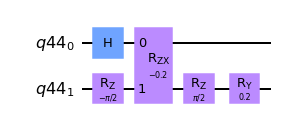

In [215]:
qc1.draw(output = "mpl")

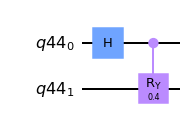

In [216]:
qc2.draw(output = "mpl")

In [217]:
psi1 = qi.Statevector.from_instruction(qc1)
psi2 = qi.Statevector.from_instruction(qc2)

In [218]:
np.amax(np.abs(psi2-psi1))

1.110417514326217e-16